# Contexto del Modelo

Este conjunto de datos está relacionado con las variantes tintas de los vinos españoles. El conjunto de datos describe varias métricas de popularidad y descripción y su efecto sobre su calidad. Los conjuntos de datos se pueden utilizar para tareas de clasificación o regresión. Las clases están ordenadas y no equilibradas (es decir, la calidad va entre 0 y 10 puntos). La tarea consiste en predecir la calidad del vino utilizando los datos proporcionados

In [ ]:
pip install pandas
pip install numpy
pip install scikit-learn
pip install lightgbm
pip install imbalanced-learn
pip install matplotlib
pip install seaborn
pip install shap
pip install pdpbox

Dataset size: (6497, 12)
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000     

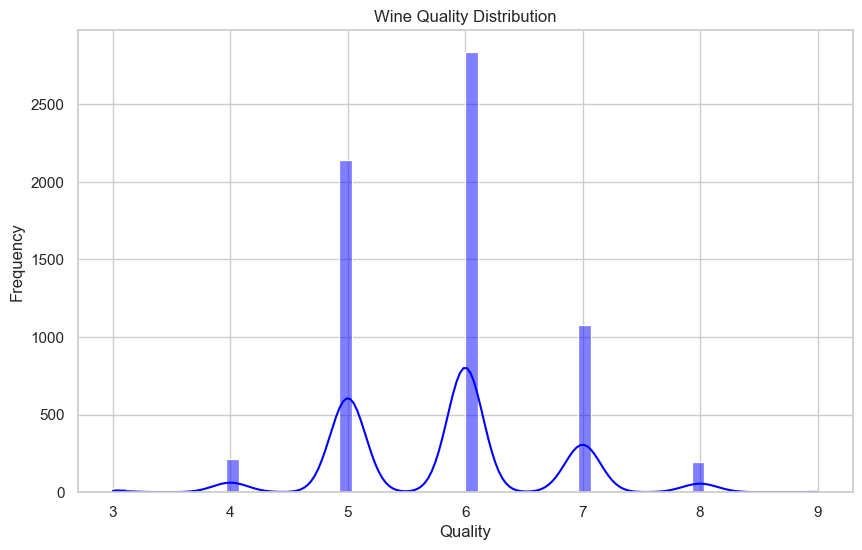

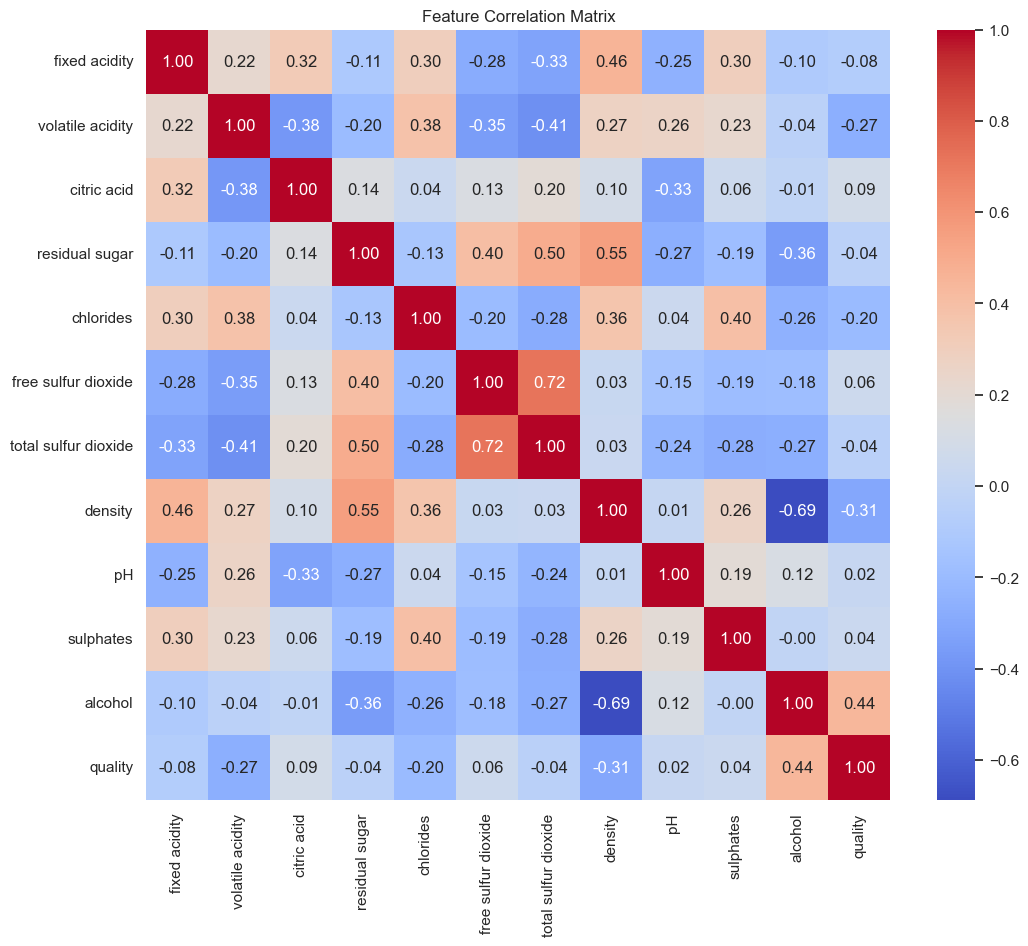

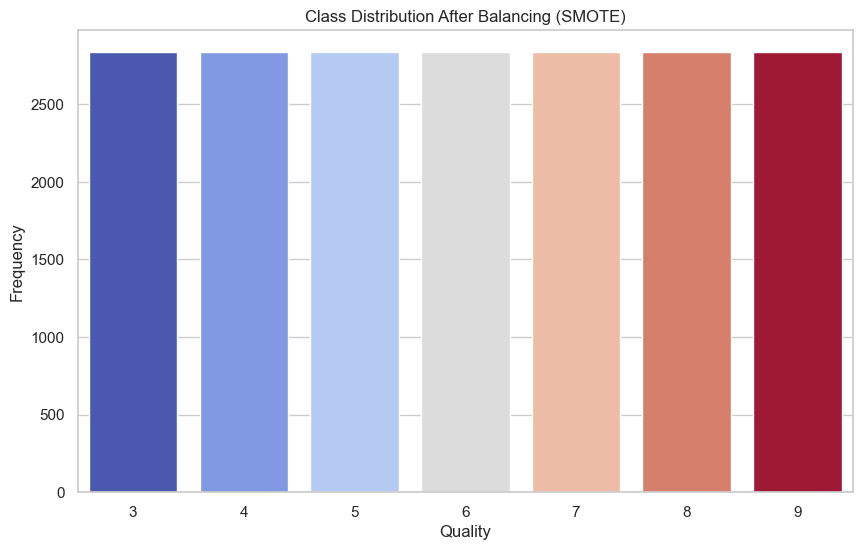

Explained variance by each component: [0.32198292 0.28091161 0.13898363 0.07296035 0.06580858 0.04008256
 0.02750389 0.02209022]
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 15881, number of used features: 8
[LightGBM] [Info] Start training from score 6.004156
Best hyperparameters: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}
Mean Absolute Error: 0.29485890144732047
Mean Squared Error: 0.22920679696102556
R² Score: 0.9419709393166434


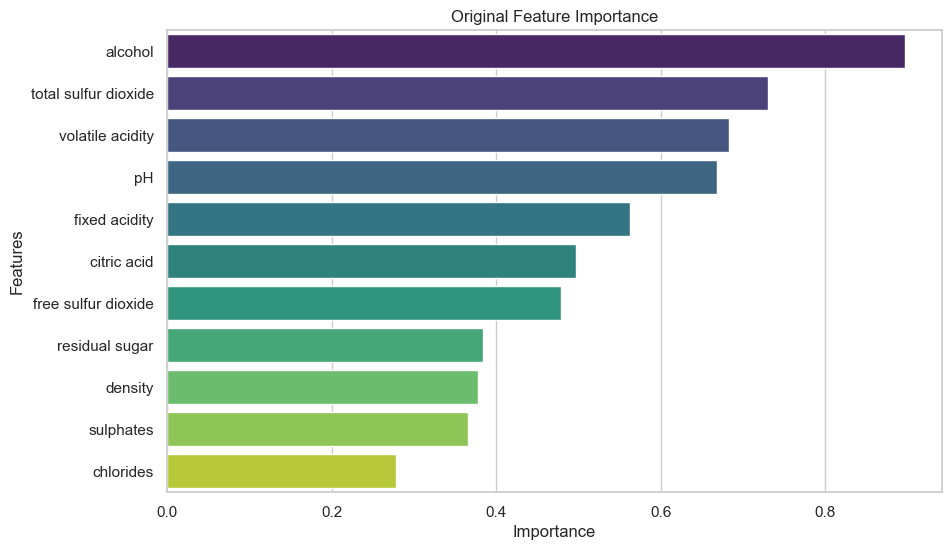

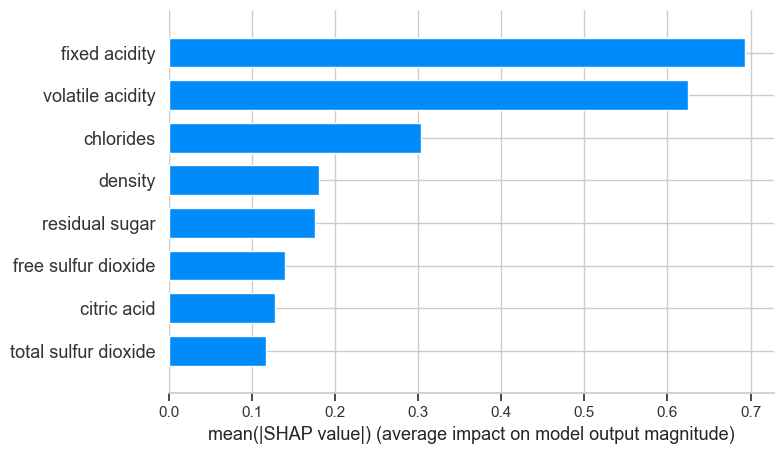

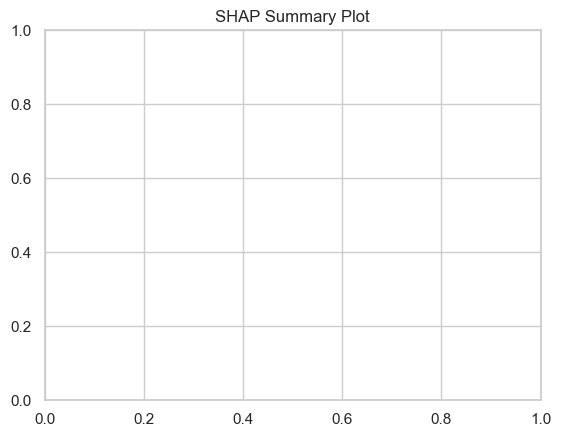

In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from pdpbox import pdp, info_plots

# Configuration to ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')
warnings.filterwarnings("ignore", category=FutureWarning, module='lightgbm')

# Configuration for plots
sns.set(style="whitegrid")

# Load and explore the data
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

# Combine the datasets
all_wine = pd.concat([red_wine, white_wine], ignore_index=True)

# Initial analysis
print("Dataset size:", all_wine.shape)
print(all_wine.describe())
print(all_wine.isnull().sum())  # Check for missing values

# Visualize the distribution of wine quality
plt.figure(figsize=(10, 6))
sns.histplot(all_wine['quality'], kde=True, color='blue')
plt.title('Wine Quality Distribution')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

# Check for multicollinearity
plt.figure(figsize=(12, 10))
sns.heatmap(all_wine.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

# Balance data with SMOTE
X = all_wine.drop('quality', axis=1)
y = all_wine['quality']

smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verify distribution after balancing
plt.figure(figsize=(10, 6))
sns.countplot(x=y_resampled, hue=y_resampled, palette="coolwarm", legend=False)
plt.title("Class Distribution After Balancing (SMOTE)")
plt.xlabel("Quality")
plt.ylabel("Frequency")
plt.show()

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Reduce dimensionality with PCA
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance by each component:", pca.explained_variance_ratio_)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.2, random_state=42)

# Train LightGBM model
lgbm = LGBMRegressor(random_state=42)

# Hyperparameter tuning
param_dist = {
    'num_leaves': [20, 31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [-1, 10, 20]
}

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

# Best model
best_lgbm = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

# Model evaluation
y_pred = best_lgbm.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Feature importance visualization
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_test)

# Transform feature importance from PCA space to original space
pca_inverse_importance = np.abs(pca.components_).T @ np.abs(shap_values).mean(axis=0)
original_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': pca_inverse_importance
}).sort_values(by='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=original_feature_importance, x='importance', y='feature', palette="viridis")
plt.title('Original Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()




